# EE2019AS (Fall 2019)

# Samer Hanna 305033107

# Lab 1

#### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb;
import time

#### Set Grid Dimensions

In [2]:
L = 8
W = 8
H = 12

### 1 (a) State Space

In [3]:
# State defined as [x position, y position, heading]
state_space = []
i=0
for h in range(H):
    for y in range(W):
        for x in range(L):
            state_space.append([x,y,h])
            i=i+1
print(len(state_space))

768


### 1 (b) Action Space

In [4]:
# Action defined as [linear action (backward, forward), rotate action]
rotate_actions = [-1,0,1] # -1 rotate counter clock wise, 0 don't rotate, 1 rotate clockwise
linear_actions = [-1,0,1] # -1 go backward, 0 don't move, 1 go forward
action_space = []
action_space.append([0,0])
for ra in rotate_actions:
    for la in linear_actions:
        if la!=0:
            action_space.append([la,ra])

action_space = (action_space)          
print(action_space)

[[0, 0], [-1, -1], [1, -1], [-1, 0], [1, 0], [-1, 1], [1, 1]]


In [5]:
# Map headings to translations
def get_translation(h):
    h = h % H
    if h in [11,0,1]:
        t = [0,1]
    elif h in [2,3,4]:
        t = [1,0]
    elif h in [5,6,7]:
        t = [0,-1]
    elif h in [8,9,10]:
        t = [-1,0]
    else:
        1/0
    return t

# Check if x y is outside of grid
def is_outside_grid(x,y):
    if x <0 or x>=L or y < 0 or y>=W:
        return True
    else:
        return False  

### 1 (c) Function for probability

In [6]:
def calc_prob_sa_to_sd(pe,s,a,sd):
    # Split each state and action into its componenets
    x,y,h = s
    xd,yd,hd = sd
    la,ra = a
    
    # Default probablity is equal to zero
    p = 0 
    
    # If no linear action, s = sd probability equal one
    if la == 0:
        possible_sd = s
        if np.all(s == sd):
            p = 1.0
    elif la in [1,-1]:
        # Treat going backward as going forward in the opposite heading
        if la == -1:
            ht = (h + 6)%H
        else:
            ht = h
        
        # Get ideal translation
        dx_ideal,dy_ideal =  get_translation(ht)
        # Get translation with plus one heading error
        dx_plus,dy_plus =  get_translation(ht+1)
        # Get translation with minus one heading error
        dx_minus,dy_minus =  get_translation(ht-1)
        
        # If sd is ideal
        if xd == x + dx_ideal and yd == y + dy_ideal:
            if hd == (h + ra) %H:
                p = 1 - 2 * pe
        # If sd is with positive heading error
        elif xd == x + dx_plus and yd == y + dy_plus:
            if hd == (h + 1 + ra) %H:
                p = pe
        # If sd is with negative heading error
        elif xd == x + dx_minus and yd == y + dy_minus:
            if hd == (h - 1 + ra) %H:
                p = pe
        # if sd is is the same as s
        elif xd ==x and yd==y:
            # If we are at the edge combine probabilities
            if is_outside_grid(x + dx_ideal,y + dy_ideal):
                if hd == (h + ra) %H:
                    p = p + 1 - 2 * pe
            if is_outside_grid(x + dx_plus,y + dy_plus):
                if hd == (h + 1 + ra) %H:
                    p = p +  pe
            if is_outside_grid(x + dx_minus,y + dy_minus):
                if hd == (h - 1 + ra) %H:
                    p = p +  pe
                
            
    return p
    

# Run some test cases to make sure we are correct

tpe = 0.1

ts = [5,5,1];ta = [-1,0];tsd = [4,5,2]
print(calc_prob_sa_to_sd(tpe,ts,ta,tsd)==tpe)

ts = [5,5,1];ta = [1,0];tsd = [6,5,2]
print(calc_prob_sa_to_sd(tpe,ts,ta,tsd)==tpe)

ts = [5,5,1];ta = [1,0];tsd = [5,6,1]
print(calc_prob_sa_to_sd(tpe,ts,ta,tsd)==1-2*tpe)


ts = [5,7,0];ta = [1,0];tsd = [5,7,0]
print(calc_prob_sa_to_sd(tpe,ts,ta,tsd) == 1-2*tpe)

ts = [5,7,0];ta = [1,0];tsd = [5,7,1]
print(calc_prob_sa_to_sd(tpe,ts,ta,tsd) == tpe)

ts = [5,0,0];ta = [-1,0];tsd = [5,0,0]
print(calc_prob_sa_to_sd(tpe,ts,ta,tsd) == 1-2*tpe)


ts = [5,7,0];ta = [1,1];tsd = [5,7,0]
print(calc_prob_sa_to_sd(tpe,ts,ta,tsd) == tpe )


True
True
True
True
True
True
True


### 1 (d) Function to get next state

In [7]:
def move(pe,s,a):
    # Sample error probability
    r = np.random.random()
    if r <= 1-2*pe:
        rotation_error = 0
    elif r<= 1 - pe:
        rotation_error = 1
    else:
        rotation_error = -1
        
    x,y,h = s
    la,ra = a
    # if no linear action
    if la == 0:
        sd = s 
    
    elif la in [1,-1]:
        # Treat going backward as going forward in the opposite heading
        if la == -1:
            ht = (h + 6)%H
        else:
            ht = h
        # Calculate new heading 
        rd = (h+ra+rotation_error)%H
        # Calculate new translation
        dx,dy =  get_translation(ht+rotation_error)
        
        xd = x + dx
        yd = y + dy
        
        # if outside grid stay in same place
        if is_outside_grid(xd,yd):
            xd = x
            yd = y
        sd = [xd,yd,rd]
    return sd
        

# Test function
print(move(0,[1,3,5],[-1,-1]))
    

[1, 4, 4]


### 2 (a) Function to Reward

In [8]:
def get_reward(s):
    # Get reward based on map
    x,y,h = s
    r = 0
    if x ==0 or y ==0 or x == W -1 or y == L -1:
        r = -100
    elif x == 3 and y in [4,5,6]:
        r = -10
    elif x == 5 and y == 6:
        r = 1
    return r

In [9]:
# Functions to transform states and actions to indices and vice-versa 

def state_to_index(s):
    return s[0] + s[1]*W + s[2]*W*L

def index_to_state(si):
    r = si//(W*L)
    y = (si - r*W*L)//W
    x = si - y*W - r*W*L
    return [x,y,r]

def action_to_index(a):
    return action_space.index(a)

def index_to_action(ai):
    return action_space[ai]

print(index_to_state(state_to_index([0,4,3])))
print(index_to_action(action_to_index([1,1])))

[0, 4, 3]
[1, 1]


### 3 Policy iteration

In [10]:
# Function to get the action that gets robot towards goad

goal = [5,6]

def calc_action_towards_goal(s):
    x,y,h = s
    # calculate angle toward goad
    angle_to_goal = np.arctan2(goal[0]-x,goal[1]-y)
    # Find heading that brings robot closer to the goal
    heading_to_goal = np.round(angle_to_goal/(2*np.pi)*H)%H
    
    # if you are at the goal don't move 
    if x==goal[0] and y == goal[1]:
        la=0
        ra=0
    else:
        # Based on heading, determine whether moving backward or forward
        # will get you closer to the goal. based on that determine required change of  heading
        if np.abs( h - heading_to_goal ) <= np.abs( (h + 6)%H - heading_to_goal ):
            la = 1
            dh = heading_to_goal -  h 
        else:
            la = -1
            dh = heading_to_goal - (h+6)%H
        
        # If required change of heading is positive rotate positive, else negative, else don't rotate
        if dh>0:
            ra = 1
        
        elif dh<0:
            ra = -1
        else:
            ra = 0
    
    return [la,ra]

print(calc_action_towards_goal([6,6,4]))

[-1, -1]


### 3 (a) Populate Pi0

In [11]:
def generate_pi0():
    pi0 = []
    for i in range(len(state_space)):
        pi0.append(action_to_index(calc_action_towards_goal(index_to_state(i))))
    return pi0
pi0 = generate_pi0()

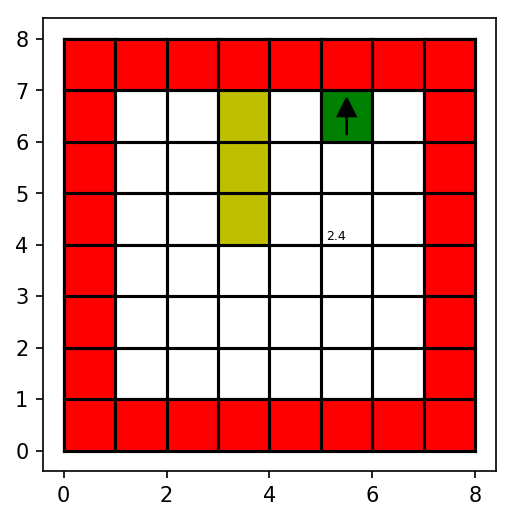

In [12]:
# Function that plots the grid

def plot_grid():
    plt.rcParams['figure.dpi'] = 150
    fig = plt.figure()
    ax=fig.add_subplot(111)
    plt.axis([0,W-1,0,L-1])
    for i in range(W+1):
        plt.plot([0,L],[i,i],'k')
    for i in range(L+1):
        plt.plot([i,i],[0,W],'k')
    plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    for x in range(W):
        ax.add_patch(patches.Rectangle((x,0),1,1,color='r'))
        ax.add_patch(patches.Rectangle((x,7),1,1,color='r'))
    for y in range(L):
        ax.add_patch(patches.Rectangle((0,y),1,1,color='r'))
        ax.add_patch(patches.Rectangle((7,y),1,1,color='r'))
    ax.add_patch(patches.Rectangle((3,4),1,1,color='y'))
    ax.add_patch(patches.Rectangle((3,5),1,1,color='y'))
    ax.add_patch(patches.Rectangle((3,6),1,1,color='y'))
    ax.add_patch(patches.Rectangle((5,6),1,1,color='g'))

# Function that plots a state
def plot_arrow(x,y,h):
#     x = 5
#     y = 6
#     h = 11
    l = 0.35

    ang = 2*np.pi/12*h
    yl = l*np.cos(ang)
    xl = l*np.sin(ang)
    arrow_len = 0.35
    plt.arrow(x+0.5-xl, y+0.5-yl,xl , yl, head_width=arrow_len, head_length=arrow_len, fc='k', ec='k')

# Function that prints text on grid
def plot_text(x,y,s):
    plt.text(x+0.1, y+0.1,s,fontsize=6)
    
plot_grid()
plot_arrow(5,6,0)
plot_text(5,4,2.4)
plt.show()
    

In [13]:
# Function populates probability matrix

def calc_prob_matrix(pe):
    P = np.zeros((len(state_space),len(action_space),len(state_space)))
    for si in range(len(state_space)):
        for ai in range(len(action_space)):
            for sdi in range(len(state_space)):
                s = index_to_state(si)
                a = index_to_action(ai)
                sd = index_to_state(sdi)
                P[si,ai,sdi] = calc_prob_sa_to_sd(pe,s,a,sd)
    return P

pe = 0
P = calc_prob_matrix(pe)                                

In [14]:
# Function populates Reward matrix
def calc_reward_matrix():
    R = np.zeros((len(state_space),))
    for si in range(len(state_space)):
                s = index_to_state(si)
                R[si] = get_reward(s)
    return R

R = calc_reward_matrix()                                

### 3 (b) (c) Plot trajectory

[1, 6, 6] [1, -1]
[1, 5, 5] [1, -1]
[1, 4, 4] [1, -1]
[2, 4, 3] [1, -1]
[3, 4, 2] [1, 0]
[4, 4, 2] [1, -1]
[5, 4, 1] [1, -1]
[5, 5, 0] [1, 0]
[5, 6, 0]


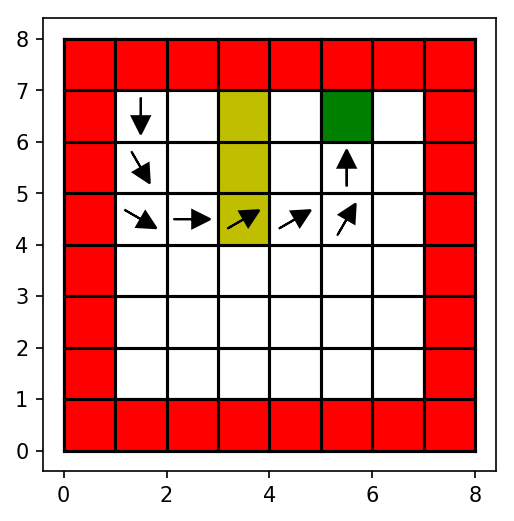

In [15]:
horizon = 100
def run_plot_policy(Pi,s0,pe,title = None,V = None,goal = [5,6]):
    plot_grid()
    traj = [s0]
    si = state_to_index(s0)
    for i in range(horizon):
#         print(i,si)
        ai = Pi[si]
        a = index_to_action(ai)
        s = index_to_state(si)
        if V is None:
            print(s,a)
        else:
            print(s,a,V[state_to_index(s)])
        if a[0]!=0:
            plot_arrow(s[0],s[1],s[2])
        sd = move(pe,s,a)
        traj.append(sd)
#         print(s,sd)
        si = int(state_to_index(sd))
        
        if len(goal)==2:
            goal_reached = sd[0] == goal[0] and sd[1] == goal[1]
        else:
            goal_reached = sd[0] == goal[0] and sd[1] == goal[1] and sd[2] == goal[2]
            
        if goal_reached:
            if V is None:
                print(sd)
            else:
                print(sd,V[state_to_index(s)])
            break
    if title is not None:
        plt.title(title)
    plt.show()
    return traj
    
traj3c = run_plot_policy(pi0,[1,6,6],0)

In [16]:
# Calculate the transition probability of a policy
def calc_P_Pi(P,Pi):
    P_Pi = np.zeros((len(state_space),len(state_space)))
    for si in range(len(state_space)):
            P_Pi[si,:] = P[si,Pi[si],:]
    return P_Pi
P_pi0 = calc_P_Pi(P,pi0)

### 3 (d) Calculate policy evalution

In [17]:
# Calculate the transition probability of a policy
def eval_policy(P,R,P_Pi,lb,V=None):
    if V is None:
        V = np.zeros_like(R)
    for itr in range(500):
        V_prev = np.copy(V)
        V = R + lb * P_Pi@V
        if (np.linalg.norm(V-V_prev))<1e-5:
            break
    return V
lb = 0.9
V = eval_policy(P,R,P_pi0,lb)

/home/samer/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 900x600 with 0 Axes>

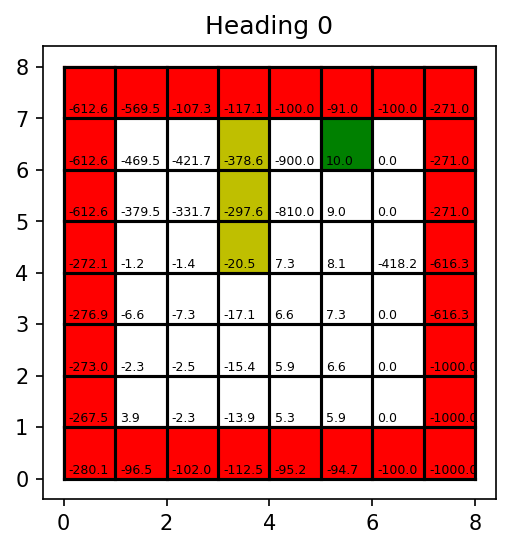

<Figure size 900x600 with 0 Axes>

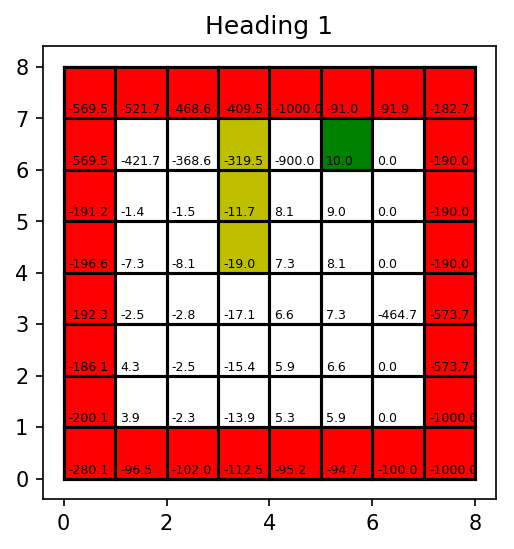

<Figure size 900x600 with 0 Axes>

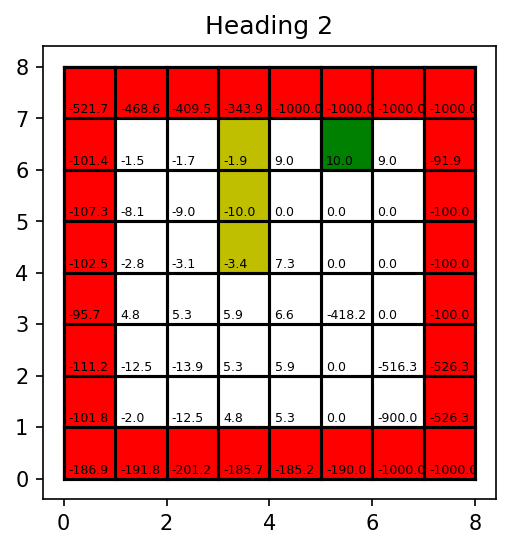

<Figure size 900x600 with 0 Axes>

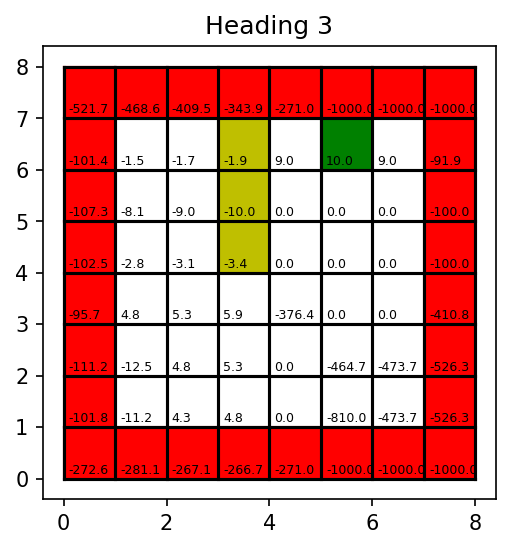

<Figure size 900x600 with 0 Axes>

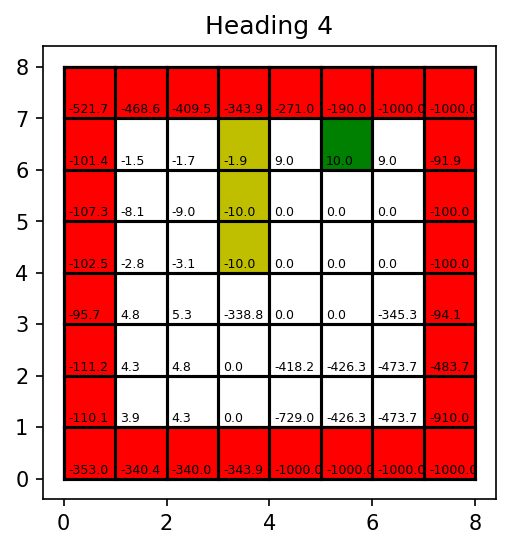

<Figure size 900x600 with 0 Axes>

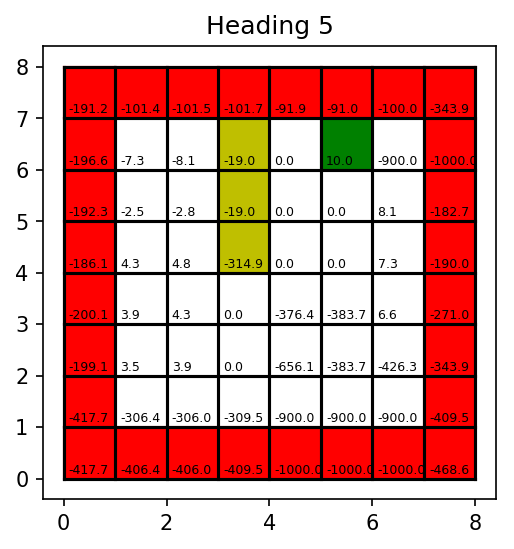

<Figure size 900x600 with 0 Axes>

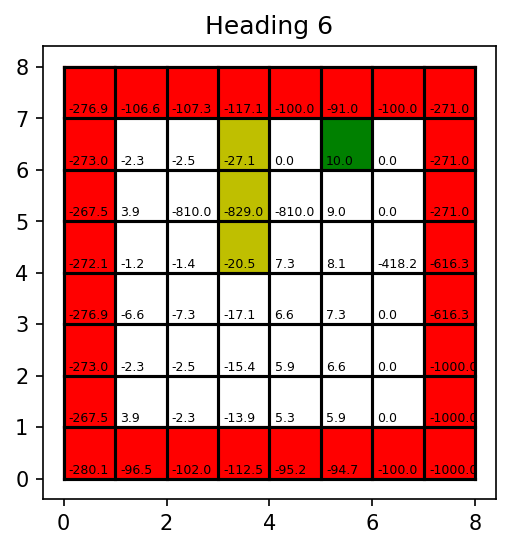

<Figure size 900x600 with 0 Axes>

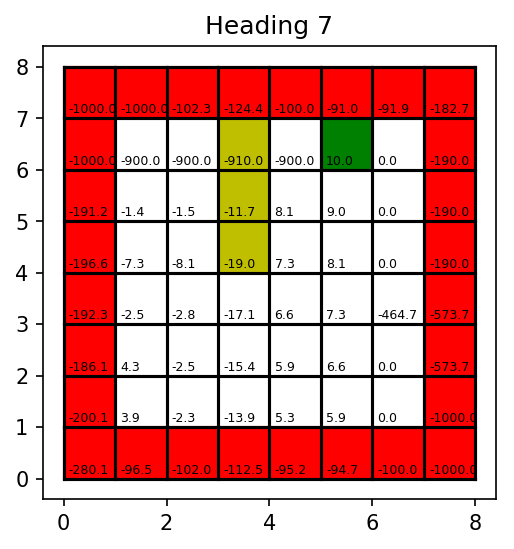

<Figure size 900x600 with 0 Axes>

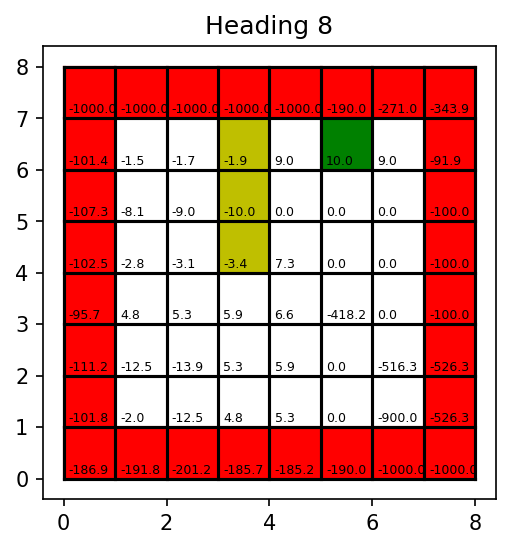

<Figure size 900x600 with 0 Axes>

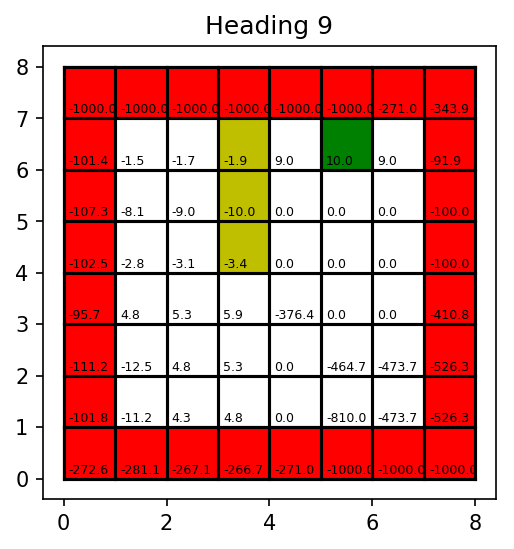

<Figure size 900x600 with 0 Axes>

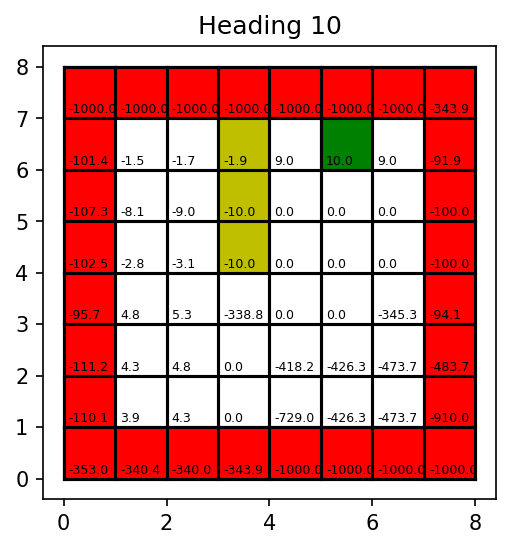

<Figure size 900x600 with 0 Axes>

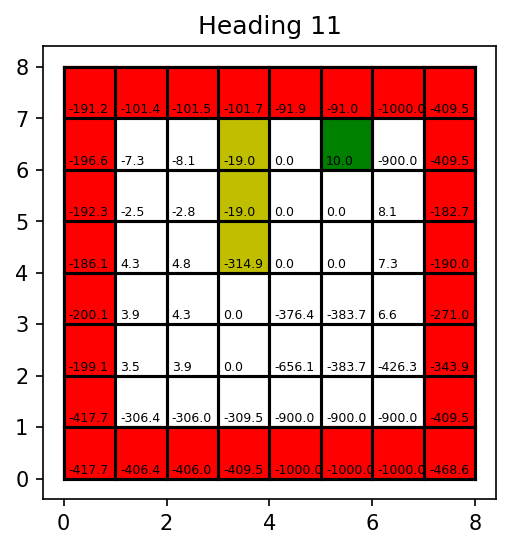

In [18]:
# Plot policy evaluation
def plot_V(V):
    for hr in range(H):
        plt.figure()
        plot_grid()
        plt.title("Heading {}".format(hr))
        for i in range(V.shape[0]):
            [x,y,h] = index_to_state(i)
            if h==hr:
                plot_text(x,y,"{:3.1f}".format(V[i]))

plot_V(V)
plt.show()

### 3 (e) Calculate value of trajectory

In [19]:
def calc_val_traj(traj):
    r = 0
    for s in traj:
        r += R[state_to_index(s)]
    return r
print(calc_val_traj(traj3c))

-9.0


### 3 (f) Calculate policy from value function

In [20]:
def get_Pi_from_V(V,P,R):
    Pi = np.zeros((len(state_space),))
    
    Vp = P@(R+lb*V)
    Pi = np.argmax(Vp,axis = -1)
    return Pi
Pi  = get_Pi_from_V(V,P,R)

### 3 (g) Run policy iteration

In [21]:
def run_policy_iteration(P,pi,R):
    pi = pi0
    V = np.zeros((len(state_space)))
    for i in range(100):
        pi_prev = np.copy(pi)
        P_pi = calc_P_Pi(P,pi)
        V = eval_policy(P,R,P_pi,lb,V)
        pi = get_Pi_from_V(V,P,R)
        # Stop when policy stops changing
        if np.all(pi==pi_prev):
            break
    return pi,V
# pir = np.random.randint(0,len(action_space),(len(state_space),))
start_time = time.time()
Pi_star, V_star  = run_policy_iteration(P,pi0,R)
delta_time_policy_iteration = (time.time() - start_time)

/home/samer/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 900x600 with 0 Axes>

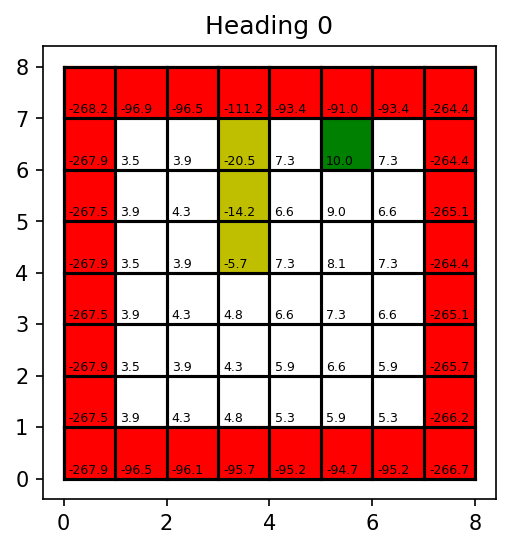

<Figure size 900x600 with 0 Axes>

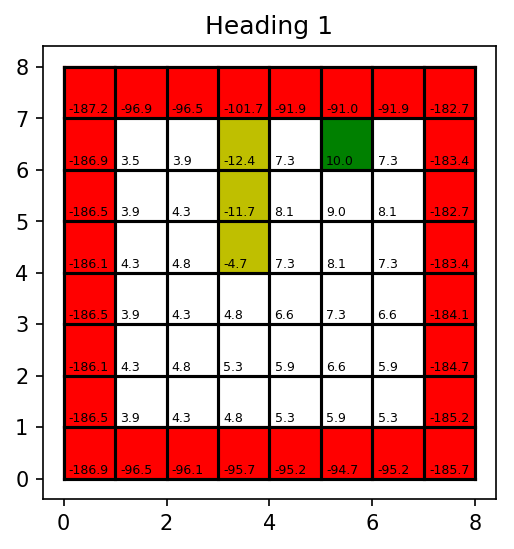

<Figure size 900x600 with 0 Axes>

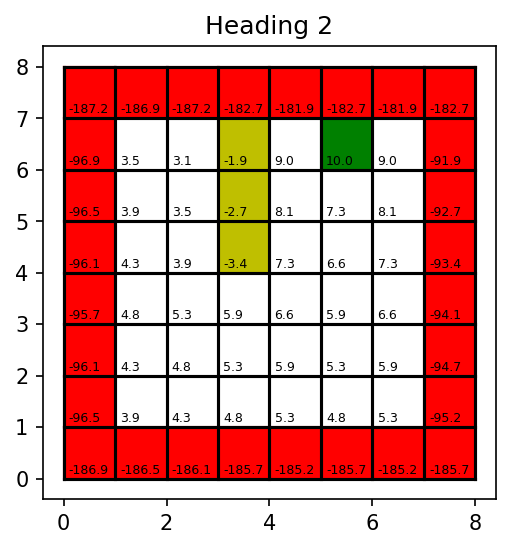

<Figure size 900x600 with 0 Axes>

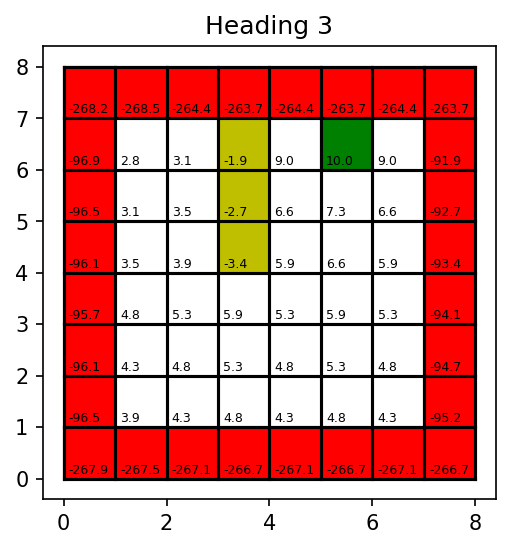

<Figure size 900x600 with 0 Axes>

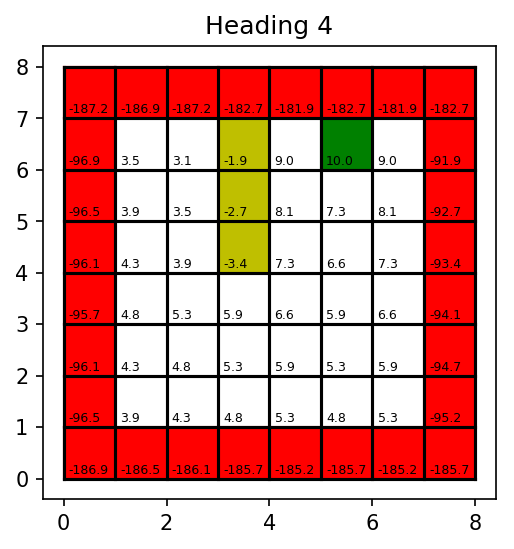

<Figure size 900x600 with 0 Axes>

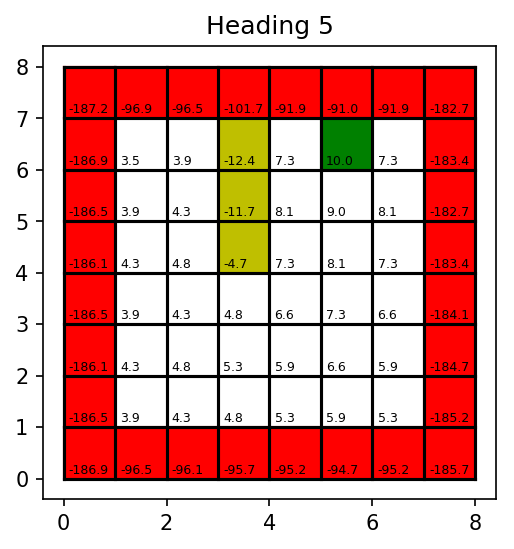

<Figure size 900x600 with 0 Axes>

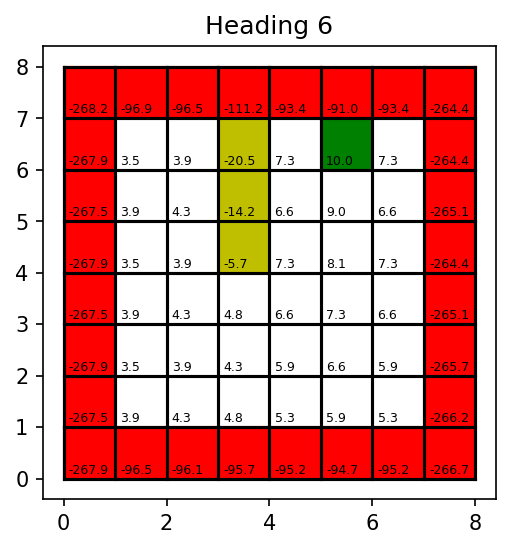

<Figure size 900x600 with 0 Axes>

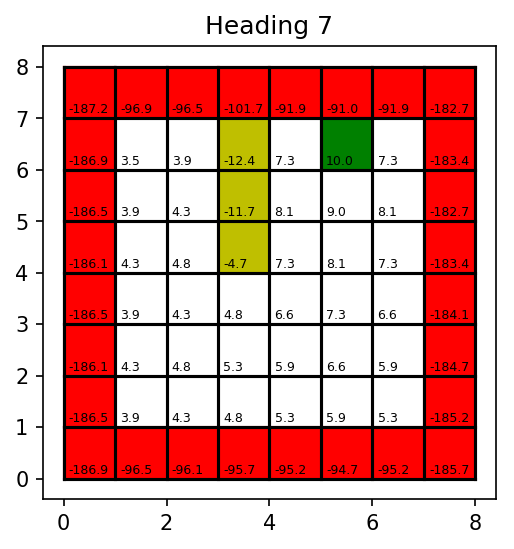

<Figure size 900x600 with 0 Axes>

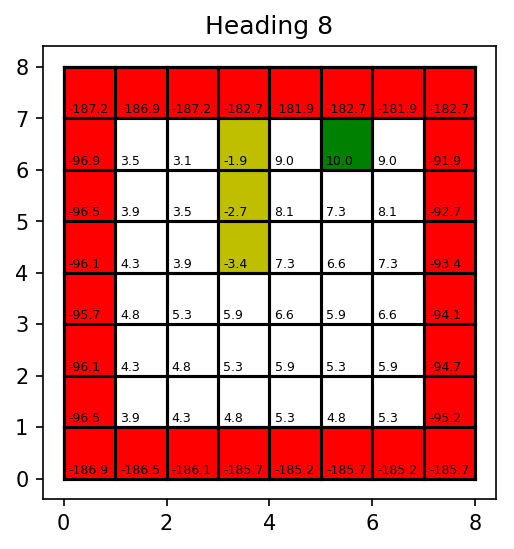

<Figure size 900x600 with 0 Axes>

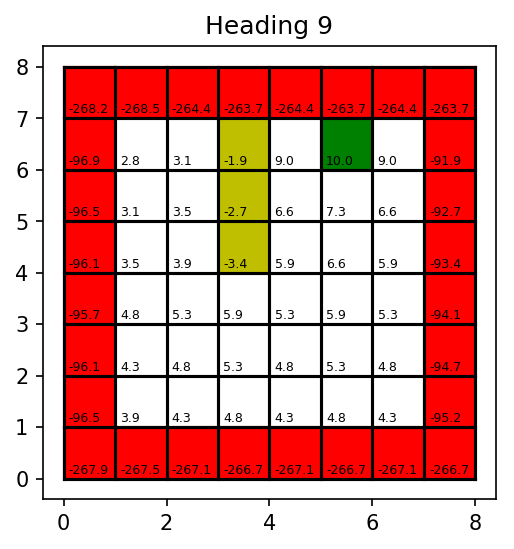

<Figure size 900x600 with 0 Axes>

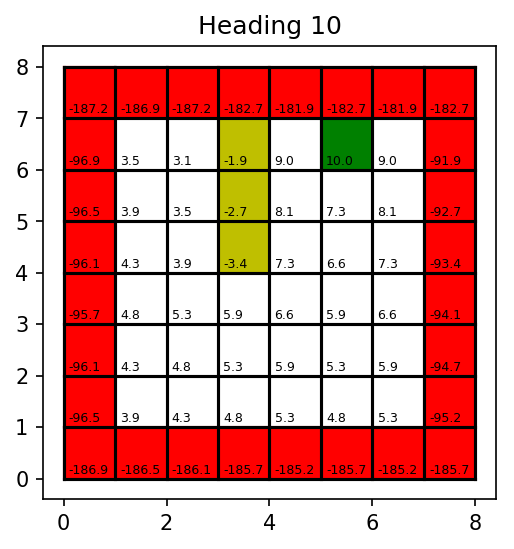

<Figure size 900x600 with 0 Axes>

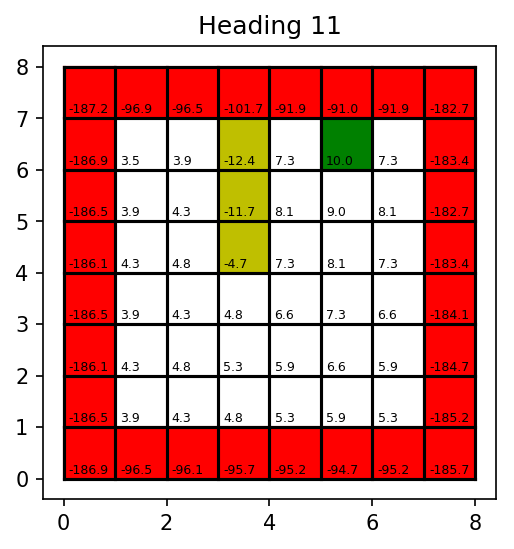

In [22]:
plot_V(V_star)

### 3 (g) Compute trajectory

[1, 6, 6] [1, -1] 3.486784400999832
[1, 5, 5] [1, -1] 3.8742048899998327
[1, 4, 4] [1, 1] 4.304672099999832
[2, 4, 5] [1, -1] 4.782968999999832
[2, 3, 4] [1, -1] 5.314409999999833
[3, 3, 3] [1, -1] 5.904899999999833
[4, 3, 2] [1, -1] 6.560999999999833
[5, 3, 1] [1, -1] 7.289999999999834
[5, 4, 0] [1, -1] 8.099999999999834
[5, 5, 11] [1, -1] 8.999999999999835
[5, 6, 10] 8.999999999999835


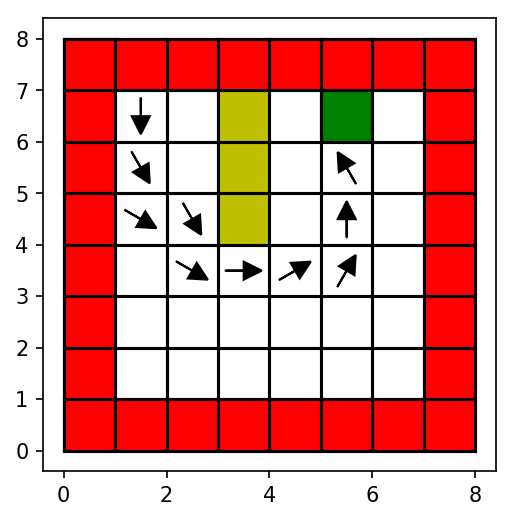

1.0


In [23]:
traj_star = run_plot_policy(Pi_star,[1,6,6],0,None,V_star)
print(calc_val_traj(traj_star))

### 3 (i) Compute time

In [24]:
print("--- %s seconds ---" % (delta_time_policy_iteration))

--- 0.20533204078674316 seconds ---


### 4 (a) Run Value Iteration

In [25]:
def run_value_iteration(P,R):
    V = np.zeros((len(state_space)))
    for i in range(100):
        V_prev = np.copy(V)
        V = np.max(P@(R + lb*V),axis=-1)
        if np.linalg.norm(V-V_prev)<1e-6:
            break
    pi = get_Pi_from_V(V,P,R)
    return pi,V
start_time = time.time()
Pi_star2, V_star2  = run_value_iteration(P,R)
delta_time_value_iteration = (time.time() - start_time)

/home/samer/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 900x600 with 0 Axes>

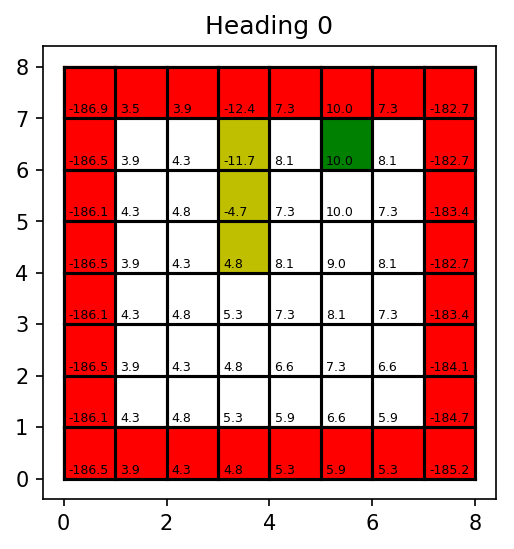

<Figure size 900x600 with 0 Axes>

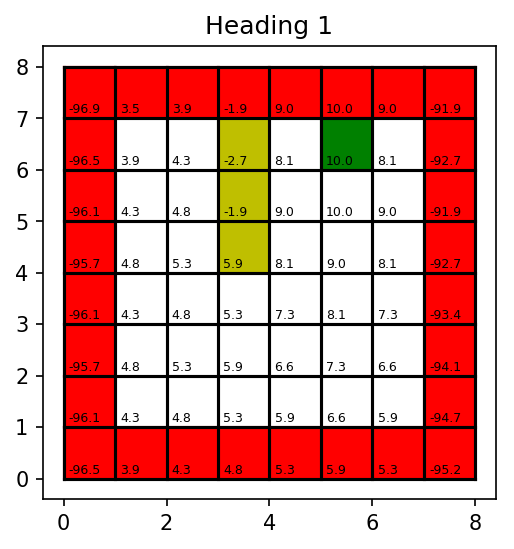

<Figure size 900x600 with 0 Axes>

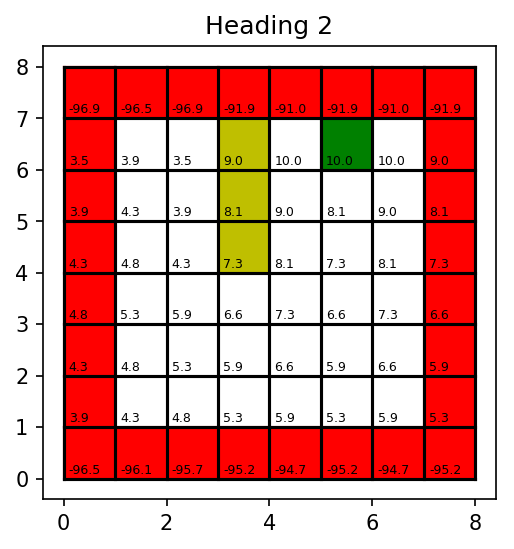

<Figure size 900x600 with 0 Axes>

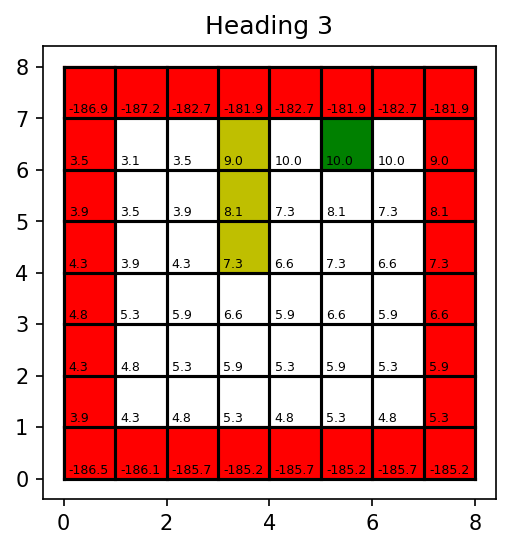

<Figure size 900x600 with 0 Axes>

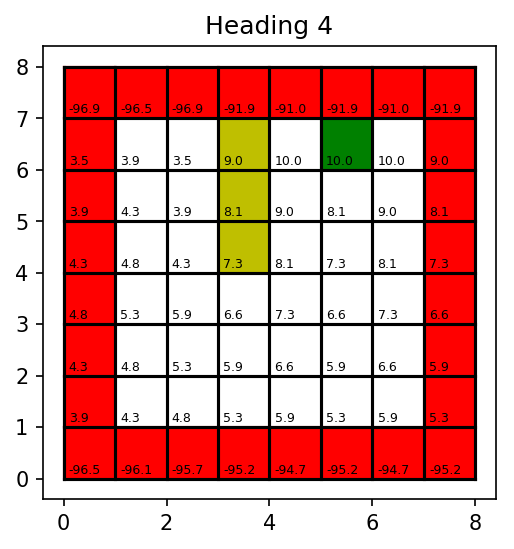

<Figure size 900x600 with 0 Axes>

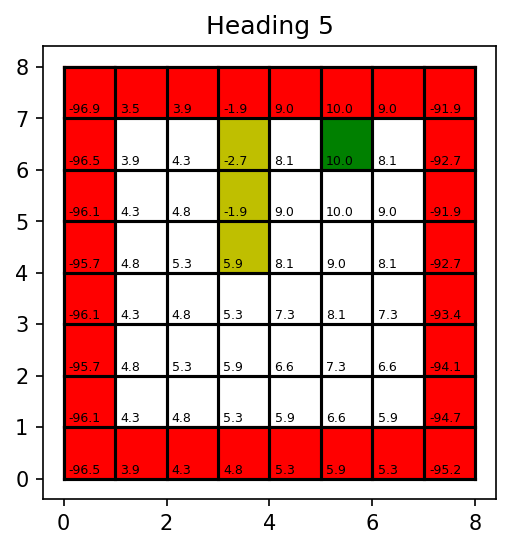

<Figure size 900x600 with 0 Axes>

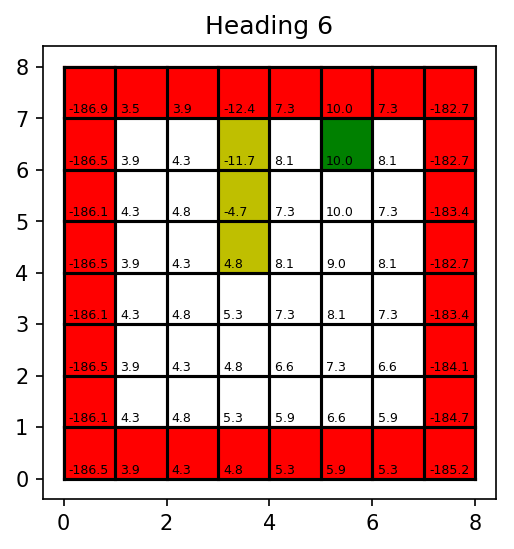

<Figure size 900x600 with 0 Axes>

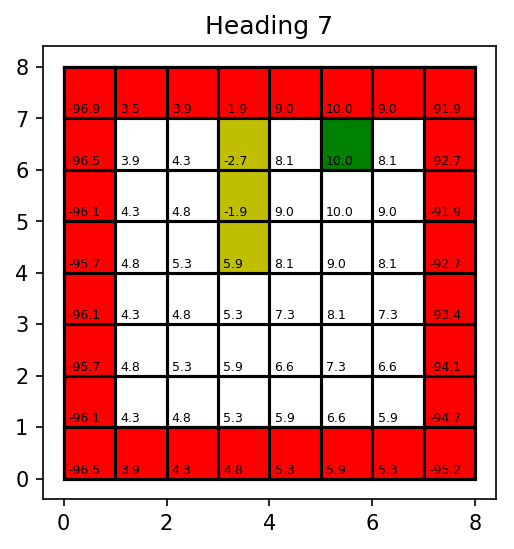

<Figure size 900x600 with 0 Axes>

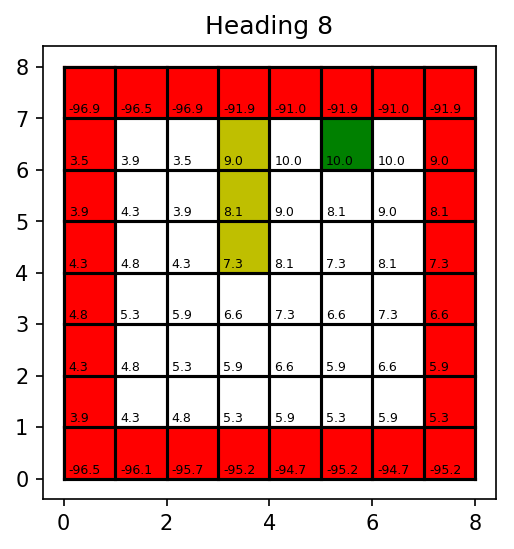

<Figure size 900x600 with 0 Axes>

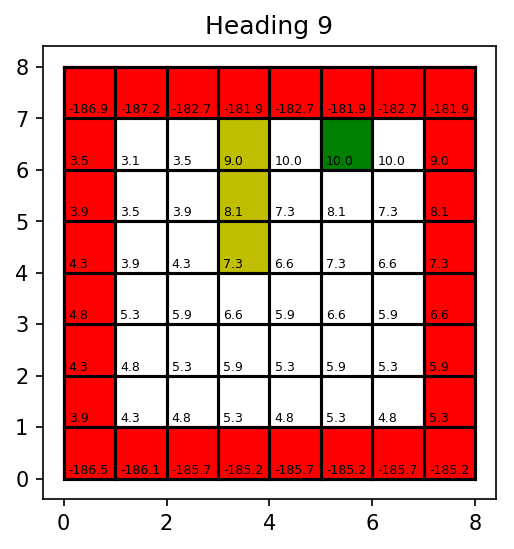

<Figure size 900x600 with 0 Axes>

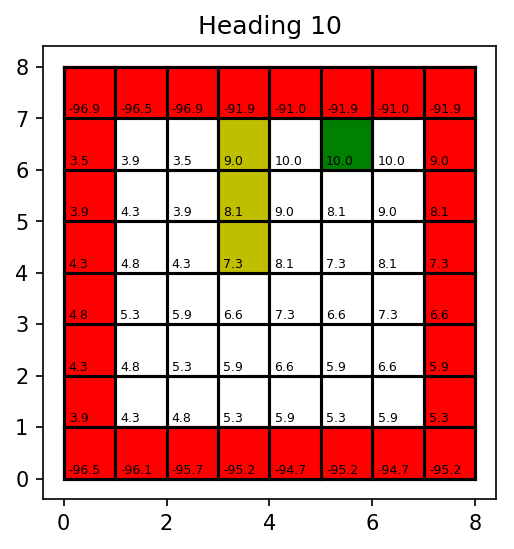

<Figure size 900x600 with 0 Axes>

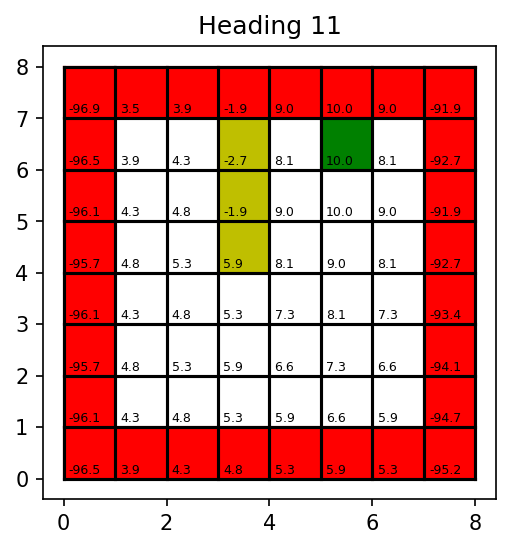

In [26]:
plot_V(V_star2)

### 4 (b) Plot trajectory

[1, 6, 6] [1, -1] 3.8739392760111255
[1, 5, 5] [1, -1] 4.304406486011126
[1, 4, 4] [1, 1] 4.782703386011126
[2, 4, 5] [1, -1] 5.314144386011125
[2, 3, 4] [1, -1] 5.904634386011125
[3, 3, 3] [1, -1] 6.560734386011125
[4, 3, 2] [1, -1] 7.289734386011126
[5, 3, 1] [1, -1] 8.099734386011127
[5, 4, 0] [1, -1] 8.999734386011127
[5, 5, 11] [1, -1] 9.999734386011127
[5, 6, 10] 9.999734386011127


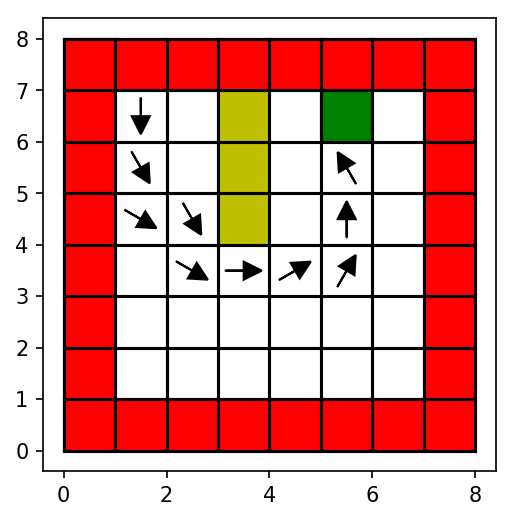

1.0


In [27]:
traj_star2 = run_plot_policy(Pi_star2,[1,6,6],0,None,V_star2)
print(calc_val_traj(traj_star2))

### 4 (c) Compute time

In [28]:
print("--- %s seconds ---" % (delta_time_value_iteration))

--- 0.2627265453338623 seconds ---


### 5 (a) Consider pe = 0.25

[1, 6, 6] [1, -1] 0.010984154440706925
[1, 5, 5] [1, 0] 0.024409452996222856
[1, 4, 5] [1, -1] 0.0465721178401001
[1, 3, 4] [1, 0] 0.09385261525517856
[2, 3, 4] [1, 0] 0.19091342513711002
[3, 3, 4] [1, 0] 0.3744448586015376
[4, 3, 4] [1, 1] 0.7354133458969652
[5, 3, 5] [-1, 0] 1.4443058614494937
[5, 4, 5] [-1, 0] 2.8418735569457123
[5, 5, 5] [-1, 0] 5.605460633540854
[5, 6, 5] 5.605460633540854


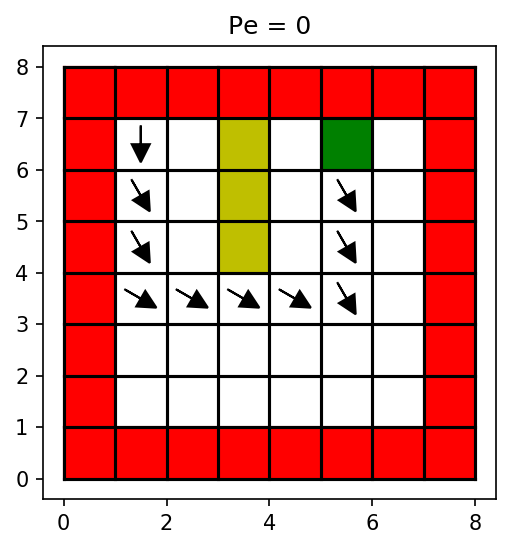

[1, 6, 6] [1, -1] 0.010984154440706925
[1, 5, 6] [1, -1] 0.020957287984971196
[1, 4, 4] [1, -1] 0.029794162109588497
[2, 4, 3] [-1, -1] 0.019283426939632968
[1, 4, 2] [1, -1] 0.04285237632562989
[1, 5, 0] [-1, -1] 0.020957287984971196
[1, 4, 10] [-1, -1] 0.029794162109588497
[2, 4, 8] [1, 1] 0.049962728545698824
[1, 4, 9] [-1, -1] 0.02248307796677524
[2, 4, 8] [1, 1] 0.049962728545698824
[2, 3, 8] [-1, 1] 0.17709174763657082
[3, 3, 9] [-1, -1] 0.3685578510811644
[4, 3, 8] [-1, -1] 0.8190211105507688
[4, 4, 6] [-1, 0] 0.7514967565860434
[4, 5, 6] [-1, -1] 1.6699988042526845
[4, 6, 5] [1, -1] 3.7111204775733633
[5, 6, 3] 3.7111204775733633


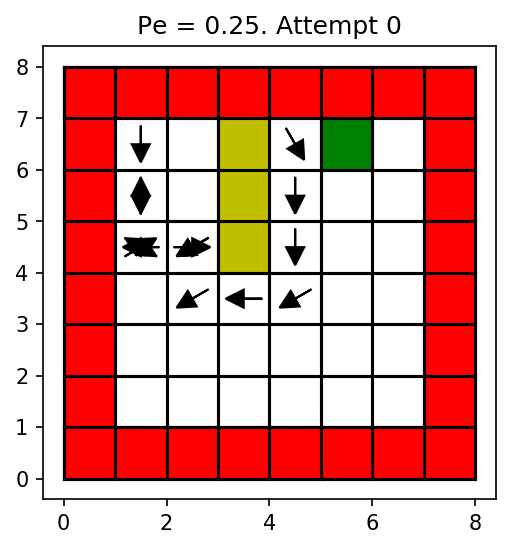

[1, 6, 6] [1, -1] 0.010984154440706925
[1, 5, 4] [1, 0] 0.01738297401498892
[2, 5, 4] [-1, 1] 0.015343105703842397
[1, 5, 5] [1, 0] 0.024409452996222856
[1, 4, 5] [1, -1] 0.0465721178401001
[2, 4, 3] [-1, -1] 0.019283426939632968
[1, 4, 2] [1, -1] 0.04285237632562989
[1, 5, 0] [-1, -1] 0.020957287984971196
[1, 4, 10] [-1, -1] 0.029794162109588497
[1, 3, 10] [-1, 0] 0.09385261525517856
[1, 2, 11] [-1, 1] 0.03529850183255201
[1, 1, 1] [1, 0] 0.04970726117938555
[2, 1, 2] [1, 0] 0.09366778131415258
[2, 2, 1] [1, 1] 0.12746551457276795
[2, 3, 1] [1, 1] 0.10540818229336685
[2, 4, 2] [-1, 1] 0.049962728545698824
[2, 3, 2] [1, 1] 0.17709174763657082
[3, 3, 4] [1, 0] 0.3744448586015376
[4, 3, 4] [1, 1] 0.7354133458969652
[5, 3, 5] [-1, 0] 1.4443058614494937
[5, 4, 5] [-1, 0] 2.8418735569457123
[4, 4, 4] [1, 1] 1.4196676977951317
[4, 3, 6] [-1, 1] 0.6259097574046412
[4, 4, 6] [-1, 0] 0.7514967565860434
[4, 5, 7] [-1, -1] 1.5993969875516016
[5, 5, 7] [-1, 0] 5.605460633540854
[5, 6, 6] 5.6054606

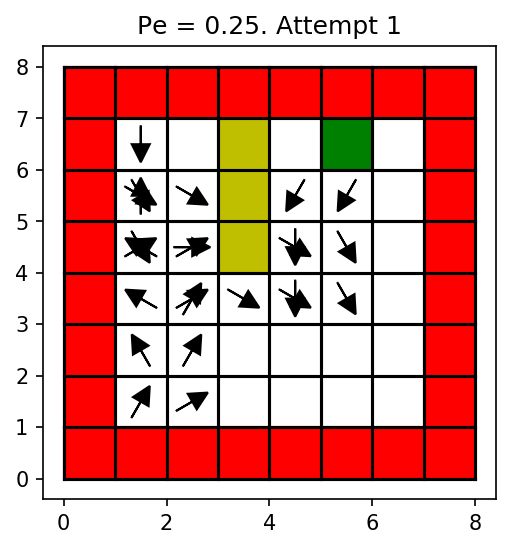

[1, 6, 6] [1, -1] 0.010984154440706925
[1, 5, 5] [1, 0] 0.024409452996222856
[1, 4, 6] [1, -1] 0.02744243545017537
[1, 3, 5] [1, -1] 0.060983639040006976
[1, 2, 4] [1, 1] 0.05127044994123796
[2, 2, 5] [-1, -1] 0.09961905629973122
[2, 3, 4] [1, 0] 0.19091342513711002
[3, 3, 4] [1, 0] 0.3744448586015376
[3, 2, 5] [-1, -1] 0.19338062569636894
[3, 3, 4] [1, 0] 0.3744448586015376
[4, 3, 3] [1, -1] 0.4366573244873886
[5, 3, 3] [-1, -1] 0.3685578510811644
[4, 3, 1] [1, 0] 0.8442384196483355
[4, 4, 0] [1, 0] 0.7514967565860434
[4, 5, 11] [-1, 1] 1.5993969875516016
[4, 4, 1] [1, -1] 1.3909160668609344
[4, 5, 0] [1, -1] 1.6699988042526845
[4, 6, 10] [-1, -1] 5.605460633540854
[5, 6, 8] 5.605460633540854


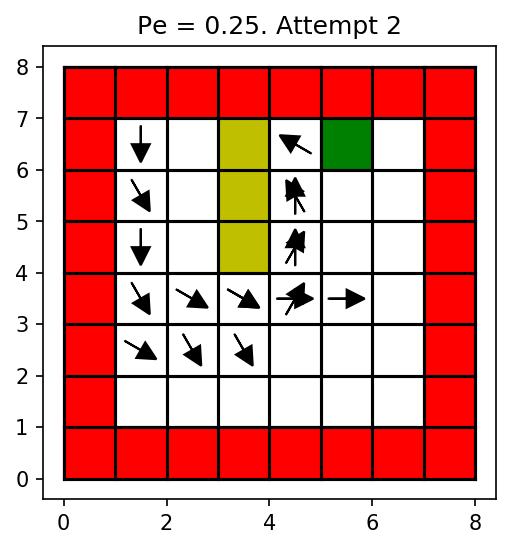

[1, 6, 6] [1, -1] 0.010984154440706925
[1, 5, 6] [1, -1] 0.020957287984971196
[1, 4, 6] [1, -1] 0.02744243545017537
[1, 3, 5] [1, -1] 0.060983639040006976
[1, 2, 4] [1, 1] 0.05127044994123796
[2, 2, 5] [-1, -1] 0.09961905629973122
[2, 3, 4] [1, 0] 0.19091342513711002
[3, 3, 4] [1, 0] 0.3744448586015376
[3, 2, 5] [-1, -1] 0.19338062569636894
[3, 3, 5] [1, 0] 0.25248799450394066
[4, 3, 4] [1, 1] 0.7354133458969652
[4, 2, 6] [-1, 1] 0.37990558201384816
[4, 3, 6] [-1, 1] 0.6259097574046412
[4, 4, 8] [-1, -1] 1.654586998842804
[5, 4, 7] [-1, 0] 2.8418735569457123
[5, 5, 6] [-1, -1] 4.999867193005564
[5, 6, 5] 4.999867193005564


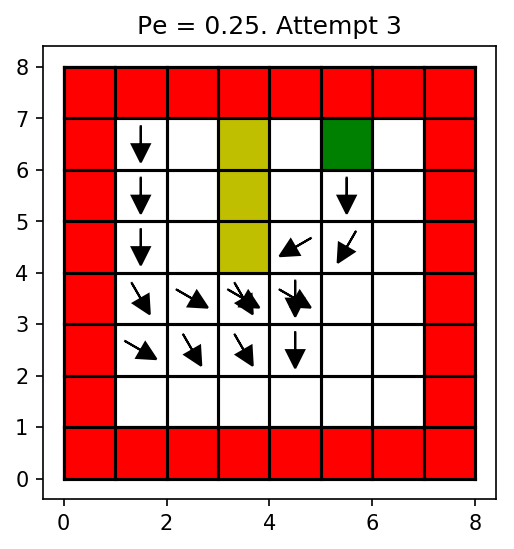

[1, 6, 6] [1, -1] 0.010984154440706925
[1, 5, 4] [1, 0] 0.01738297401498892
[1, 4, 5] [1, -1] 0.0465721178401001
[2, 4, 3] [-1, -1] 0.019283426939632968
[1, 4, 3] [1, -1] 0.02248307796677524
[2, 4, 2] [-1, 1] 0.049962728545698824
[1, 4, 4] [1, -1] 0.029794162109588497
[2, 4, 2] [-1, 1] 0.049962728545698824
[1, 4, 3] [1, -1] 0.02248307796677524
[2, 4, 2] [-1, 1] 0.049962728545698824
[1, 4, 3] [1, -1] 0.02248307796677524
[2, 4, 2] [-1, 1] 0.049962728545698824
[1, 4, 3] [1, -1] 0.02248307796677524
[2, 4, 3] [-1, -1] 0.019283426939632968
[1, 4, 2] [1, -1] 0.04285237632562989
[1, 5, 0] [-1, -1] 0.020957287984971196
[1, 4, 11] [-1, -1] 0.0465721178401001
[2, 4, 9] [1, -1] 0.019283426939632968
[1, 4, 9] [-1, -1] 0.02248307796677524
[2, 4, 7] [1, 1] 0.08474949187291628
[2, 3, 7] [-1, 1] 0.10540818229336685
[2, 4, 7] [1, 1] 0.08474949187291628
[2, 3, 7] [-1, 1] 0.10540818229336685
[2, 4, 8] [1, 1] 0.049962728545698824
[1, 4, 10] [-1, -1] 0.029794162109588497
[1, 3, 10] [-1, 0] 0.093852615255178

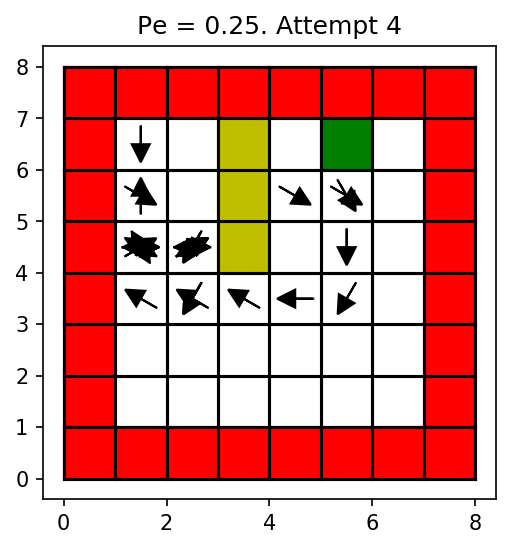

In [29]:
 def eval_pe(pe,R,goal = [5,6]):
    P = calc_prob_matrix(pe)  
    Pi_star, V_star  = run_value_iteration(P,R)
    traj_star = run_plot_policy(Pi_star,[1,6,6],0,"Pe = 0",V_star,goal)
    if pe>0:
        for i in range(5):
            traj_star = run_plot_policy(Pi_star,[1,6,6],pe,"Pe = 0.25. Attempt {}".format(i),V_star)


eval_pe(0.25,R)

### 5 (b) Reward 

In [30]:
def get_reward2(s):
    # Get reward based on map
    x,y,h = s
    r = 0
    if x ==0 or y ==0 or x == W -1 or y == L -1:
        r = -100
    elif x == 3 and y in [4,5,6]:
        r = -10
    elif x == 5 and y == 6 and h == 6:
        r = 1
    return r

def calc_reward_matrix2():
    R = np.zeros((len(state_space),))
    for si in range(len(state_space)):
                s = index_to_state(si)
                R[si] = get_reward2(s)
    return R

In [31]:
def calc_heading_reward(pe):
    goal = [5,6,6]
    R = calc_reward_matrix2()
    eval_pe(pe,R,goal)


[1, 6, 6] [1, -1] 3.8739392760111255
[1, 5, 5] [1, -1] 4.304406486011126
[1, 4, 4] [1, 1] 4.782703386011126
[2, 4, 5] [1, -1] 5.314144386011125
[2, 3, 4] [1, -1] 5.904634386011125
[3, 3, 3] [1, 1] 6.560734386011125
[4, 3, 4] [1, 1] 7.289734386011126
[5, 3, 5] [-1, 0] 8.099734386011127
[5, 4, 5] [-1, 0] 8.999734386011127
[5, 5, 5] [-1, 1] 9.999734386011127
[5, 6, 6] 9.999734386011127


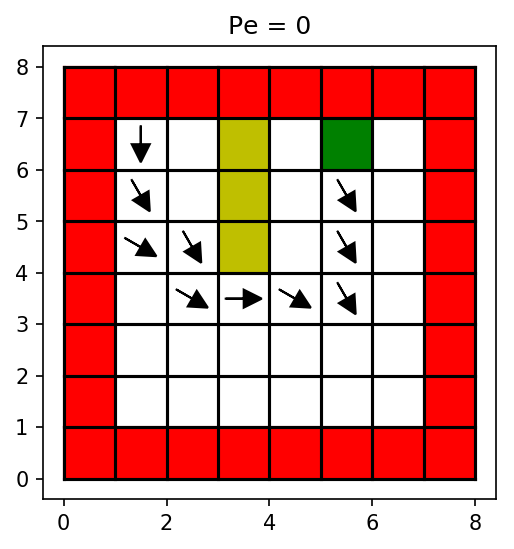

In [32]:
calc_heading_reward(0.0)

[1, 6, 6] [1, -1] 0.010268633842907816
[1, 5, 5] [1, 0] 0.022819390384762186
[1, 4, 5] [1, -1] 0.04352411073093901
[1, 3, 4] [1, 0] 0.08841568889149103
[2, 3, 4] [1, 0] 0.18007546085183612
[3, 3, 4] [1, 0] 0.3542270721848851
[4, 3, 4] [1, 1] 0.6982187410682301
[5, 3, 5] [-1, 0] 1.3746535661635437
[5, 4, 5] [-1, 0] 2.705687299687513
[5, 5, 5] [-1, 1] 5.338767253533646
[5, 6, 6] 5.338767253533646


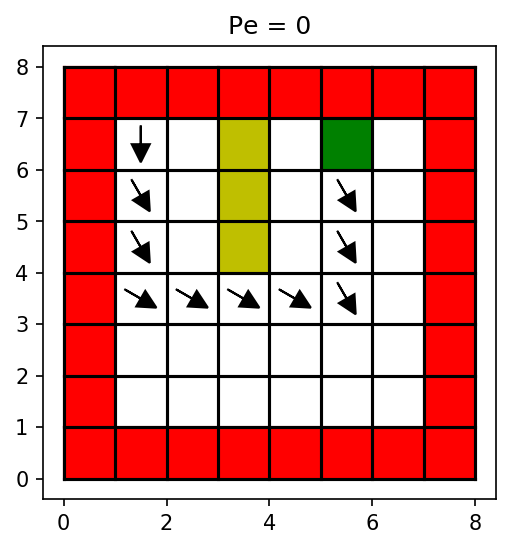

[1, 6, 6] [1, -1] 0.010268633842907816
[1, 5, 6] [1, -1] 0.01958569743326626
[1, 4, 5] [1, -1] 0.04352411073093901
[2, 4, 3] [-1, -1] 0.016610468982580617
[1, 4, 3] [1, -1] 0.019166904026113325
[2, 4, 1] [-1, 1] 0.0722492554094747
[2, 3, 2] [1, 1] 0.15097138811010055
[3, 3, 3] [1, 1] 0.3141970029867323
[4, 3, 5] [-1, -1] 0.6771925272790245
[4, 4, 4] [1, 1] 1.3477798932256877
[5, 4, 5] [-1, 0] 2.705687299687513
[4, 4, 4] [1, 1] 1.3477798932256877
[5, 4, 5] [-1, 0] 2.705687299687513
[5, 5, 5] [-1, 1] 5.338767253533646
[4, 5, 5] [1, 1] 1.5062278571750924
[4, 4, 6] [-1, -1] 0.6778001210561655
[4, 5, 4] [1, 1] 2.554942443641743
[5, 5, 4] [-1, 1] 3.1777337175589473
[4, 5, 5] [1, 1] 1.5062278571750924
[5, 5, 5] [-1, 1] 5.338767253533646
[5, 6, 6] 5.338767253533646


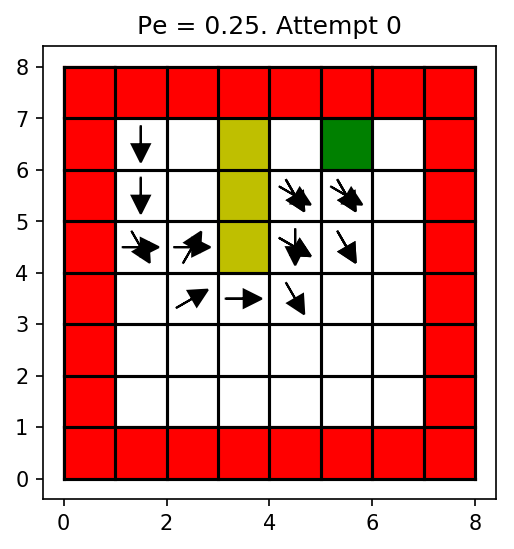

[1, 6, 6] [1, -1] 0.010268633842907816
[1, 5, 5] [1, 0] 0.022819390384762186
[1, 4, 5] [1, -1] 0.04352411073093901
[2, 4, 3] [-1, -1] 0.016610468982580617
[1, 4, 2] [1, -1] 0.0369124282855689
[2, 4, 2] [-1, 1] 0.04259340904671067
[1, 4, 3] [1, -1] 0.019166904026113325
[2, 4, 2] [-1, 1] 0.04259340904671067
[2, 3, 2] [1, 1] 0.15097138811010055
[3, 3, 3] [1, 1] 0.3141970029867323
[4, 3, 5] [-1, -1] 0.6771925272790245
[4, 4, 5] [1, 1] 0.8692271894461091
[4, 3, 6] [-1, 1] 0.5787795280374237
[4, 4, 8] [-1, -1] 1.3477798932256877
[5, 4, 7] [-1, 0] 2.705687299687513
[5, 5, 6] [-1, 0] 4.999867193005564
[5, 6, 6] 4.999867193005564


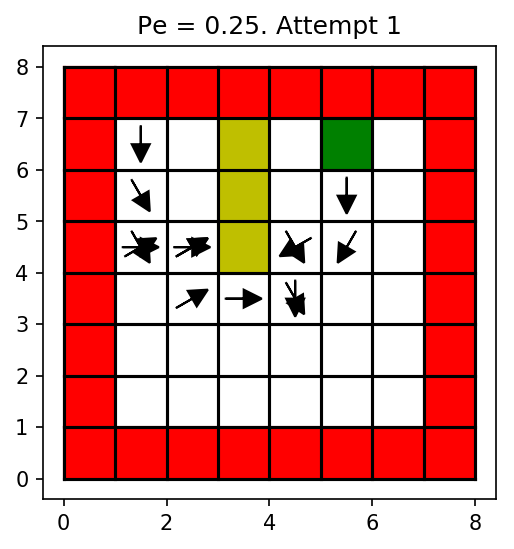

[1, 6, 6] [1, -1] 0.010268633842907816
[1, 5, 5] [1, 0] 0.022819390384762186
[1, 4, 6] [1, -1] 0.025740818454558268
[1, 3, 4] [1, 0] 0.08841568889149103
[2, 3, 4] [1, 0] 0.18007546085183612
[3, 3, 4] [1, 0] 0.3542270721848851
[4, 3, 3] [1, 1] 0.415336770600533
[5, 3, 5] [-1, 0] 1.3746535661635437
[5, 4, 5] [-1, 0] 2.705687299687513
[5, 5, 5] [-1, 1] 5.338767253533646
[5, 6, 6] 5.338767253533646


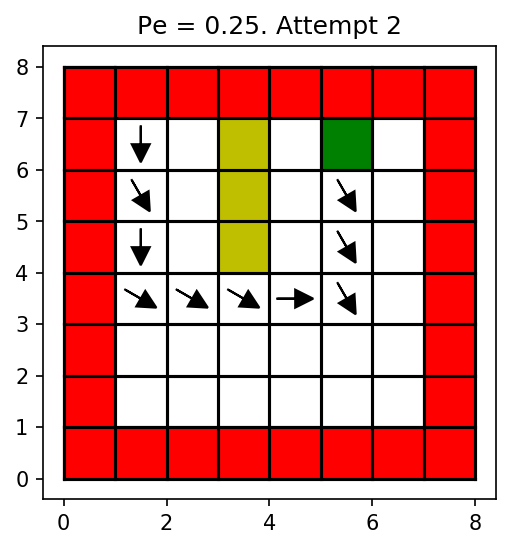

[1, 6, 6] [1, -1] 0.010268633842907816
[1, 5, 5] [1, 0] 0.022819390384762186
[1, 4, 6] [1, -1] 0.025740818454558268
[1, 3, 4] [1, 0] 0.08841568889149103
[2, 3, 3] [1, 1] 0.15940134733618513
[3, 3, 5] [1, 0] 0.23715863988967167
[3, 2, 6] [-1, -1] 0.1067207905268045
[3, 3, 4] [1, 0] 0.3542270721848851
[3, 2, 5] [-1, -1] 0.1779124844364786
[3, 3, 4] [1, 0] 0.3542270721848851
[4, 3, 4] [1, 1] 0.6982187410682301
[5, 3, 5] [-1, 0] 1.3746535661635437
[5, 4, 5] [-1, 0] 2.705687299687513
[5, 5, 5] [-1, 1] 5.338767253533646
[5, 6, 7] 5.338767253533646


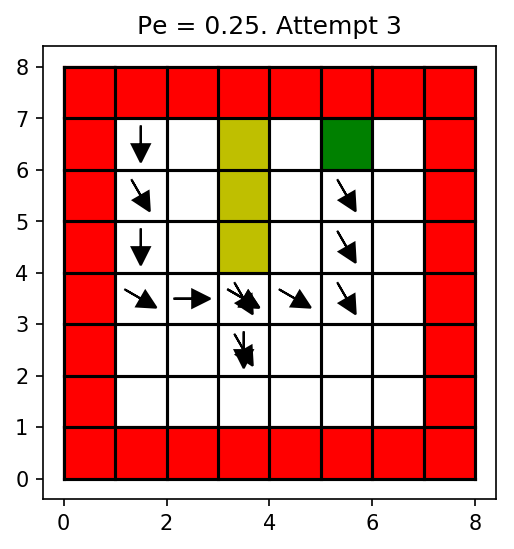

[1, 6, 6] [1, -1] 0.010268633842907816
[1, 5, 5] [1, 0] 0.022819390384762186
[1, 4, 5] [1, -1] 0.04352411073093901
[1, 3, 5] [1, -1] 0.05720223468455256
[1, 2, 4] [1, 1] 0.04741623520198143
[2, 2, 4] [1, 0] 0.09294675200775881
[3, 2, 4] [1, 0] 0.1828283733470235
[4, 2, 3] [1, 1] 0.21239691729695875
[5, 2, 4] [-1, 0] 0.47199547019351895
[5, 3, 5] [-1, 0] 1.3746535661635437
[4, 3, 4] [1, 1] 0.6982187410682301
[5, 3, 5] [-1, 0] 1.3746535661635437
[5, 4, 5] [-1, 0] 2.705687299687513
[4, 4, 4] [1, 1] 1.3477798932256877
[5, 4, 5] [-1, 0] 2.705687299687513
[5, 5, 5] [-1, 1] 5.338767253533646
[5, 6, 6] 5.338767253533646


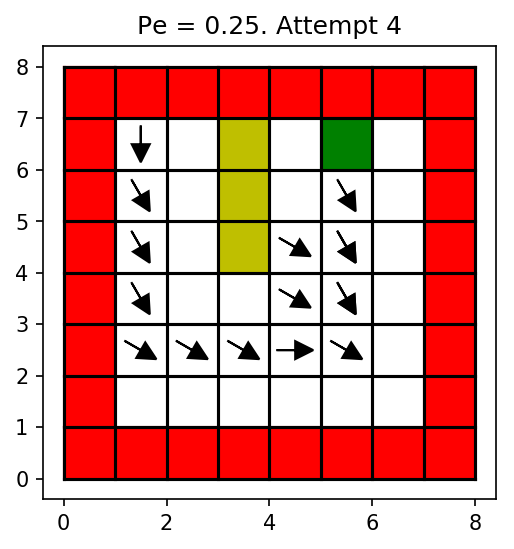

In [33]:
calc_heading_reward(0.25)